# Volcano Plots
# Phase 2 vs. Phase 2

using results from [deseq_p2.v.p2.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/deseq_p2.v.p2.ipynb) to generate publication-formatted volcano plots

## 0. load libraries

In [2]:
library(tidyverse) # for ggplot and dplyr
library(cowplot) # for combining plots

## 1. Load CSVs


From looking at differnet comparisons, the DESeq analysis resulted in 36 output files. These contain *all genes*. Here, I start by assigning directionality for genes and write CSVs that contain only DEGs.

In [3]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes',
    pattern = '\\.csv$',
    full.names = TRUE
    )

head(files)

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv"
[2] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_bb.csv"
[3] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cc.csv"
[4] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_hc.csv"
[5] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_wc.csv"
[6] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_ch.csv"

The order of oyster treatment is intential - the oyster listed second is the 'baseline' from DESeq. In other words, If the file name is bb_cc.csv, then the LFC values are for BB in relation to CC (a +lfc = more expression in BB, a -lfc = more expression in CC)

I want to read in a csv, assign directionality to DEGs (or mark genes as not significant)

In [4]:
# create function
deg_list <- lapply(files, function(f) {

    # read file
  df <- read.csv(f)

    # get basename of file without extension (so just bb_cc if bb_cc.csv
  name <- tools::file_path_sans_ext(basename(f))
    # separate the two treatments (bb and cc)
  groups <- strsplit(name, "_")[[1]]
    # assign treatment names to variables
  g1 <- toupper(groups[1]) # BB
  g2 <- toupper(groups[2]) # CC

    # add comparison column
    df$pair <- paste(g2, 'vs.', g1)

  # set default for new col to NS (not significant)
  df$DEG_group <- "NS"

  # upregulated DEGs
  df$DEG_group[df$padj < 0.05 & df$log2FoldChange >  1] <- g1 # bb if cc is baseline

  # downregulated DEGs
  df$DEG_group[df$padj < 0.05 & df$log2FoldChange < -1] <- g2 

  df
})


In [5]:
# name list elements after the files
names(deg_list) <- tools::file_path_sans_ext(basename(files))

# basename() removes directory path, keeps only the filename
# tools::file_path_sans_exta(...) removes the file extension (.csv)
# names(deg_list) assigns those filenames as the names of the list elements
# now can access elements by name

writing out *only* DEGs for downstream analysis

In [6]:
out_dir <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs"  

for (nm in names(deg_list)) {

  df <- deg_list[[nm]]

  deg_df <- df[!is.na(df$DEG_group) & df$DEG_group != "NS", ]

  write.csv(
    deg_df,
    file = file.path(out_dir, paste0("DEG_", nm, ".csv")),
    row.names = FALSE
  )
}


## 2. using `ggplot` to make volcano plots

#### 1. single exposure experienced early in life affects GE
- CC vs. WC
- CC vs. HC
- CC vs. BC

In [7]:
# combining dfs
comp1 <- rbind(deg_list$wc_cc, deg_list$hc_cc, deg_list$bc_cc)

# check things look okay
head(comp1)
tail(comp1)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111116054,9.0629842,1.684013e-04,0.018305639,0.44047770,0.6595912,1,0.9899086,1.875059,5.965799,⋯,11.19491,2.006592,7.359253,5.277065,2.300668,21.05700,1.075999,0.0000,CC vs. WC,NS
2,LOC111126949,539.2853993,-1.510958e-05,0.007741036,-0.09086219,0.9276021,1,0.9930892,829.713451,474.281013,⋯,506.25864,742.439160,650.373981,428.497663,480.839693,469.90350,302.355713,636.4963,CC vs. WC,NS
3,LOC111110729,114.0070007,9.793524e-05,0.006851507,0.55548287,0.5785644,1,0.9936909,60.001877,92.469883,⋯,87.07151,149.491128,111.308701,121.372491,144.942108,119.69240,136.651870,226.3334,CC vs. WC,NS
4,LOC111112434,6.9517032,-2.714075e-04,0.028635977,-0.40259431,0.6872467,1,0.9881456,10.312823,1.988600,⋯,13.68267,6.019777,3.679626,0.000000,2.300668,17.73221,8.607992,0.0000,CC vs. WC,NS
5,LOC111120752,429.0263780,-2.276593e-04,0.009449425,-1.11800790,0.2635636,1,0.9926109,337.510556,334.084739,⋯,446.55246,346.137176,402.919100,293.404804,330.145914,461.03739,358.307660,456.9172,CC vs. WC,NS
6,LOC111128944,0.1088474,0.000000e+00,0.337332140,0.00000000,1.0000000,NA,0.9612649,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,CC vs. WC,NS


,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
106393,ND4,201238.59,-1.907851e-05,0.006542229,-0.119109564,0.9051886,1,0.9907355,172931.034,128590.81,⋯,232657.56,161231.700,158969.063,150933.553,246913.48,184216.58,148150.00,210908.75,CC vs. BC,NS
106394,ND5,210564.28,-7.458953e-06,0.006435080,-0.045742783,0.9635153,1,0.9909277,185647.681,161139.21,⋯,285619.43,168043.078,141437.483,250349.232,295052.67,146413.73,210493.38,240616.87,CC vs. BC,NS
106395,ND6,63225.38,-1.572074e-04,0.008677439,-0.885599092,0.3758336,1,0.9888614,39229.977,49181.05,⋯,65037.44,69710.021,45142.578,53080.940,55572.64,51206.18,51296.10,60055.93,CC vs. BC,NS
106396,ND3,37297.98,-5.736497e-06,0.007147789,-0.037278405,0.9702630,1,0.9900555,21388.794,31453.68,⋯,45645.37,34658.866,31963.075,34293.533,39744.05,27421.75,30488.43,31331.77,CC vs. BC,NS
106397,ND1,182099.48,1.568375e-06,0.006548946,0.009841602,0.9921477,1,0.9907850,138760.903,151767.94,⋯,194277.69,147349.091,142097.976,152530.392,260604.76,147909.88,187075.33,248166.63,CC vs. BC,NS
106398,ND4L,12213.37,4.793846e-05,0.007000079,0.305854776,0.7597152,1,0.9900781,9108.097,10568.41,⋯,11910.14,9407.908,9196.306,9447.001,17288.37,10859.87,11466.92,16002.73,CC vs. BC,NS


Warning message:
“Removed 4508 rows containing missing values or values outside the scale range
(`geom_point()`).”


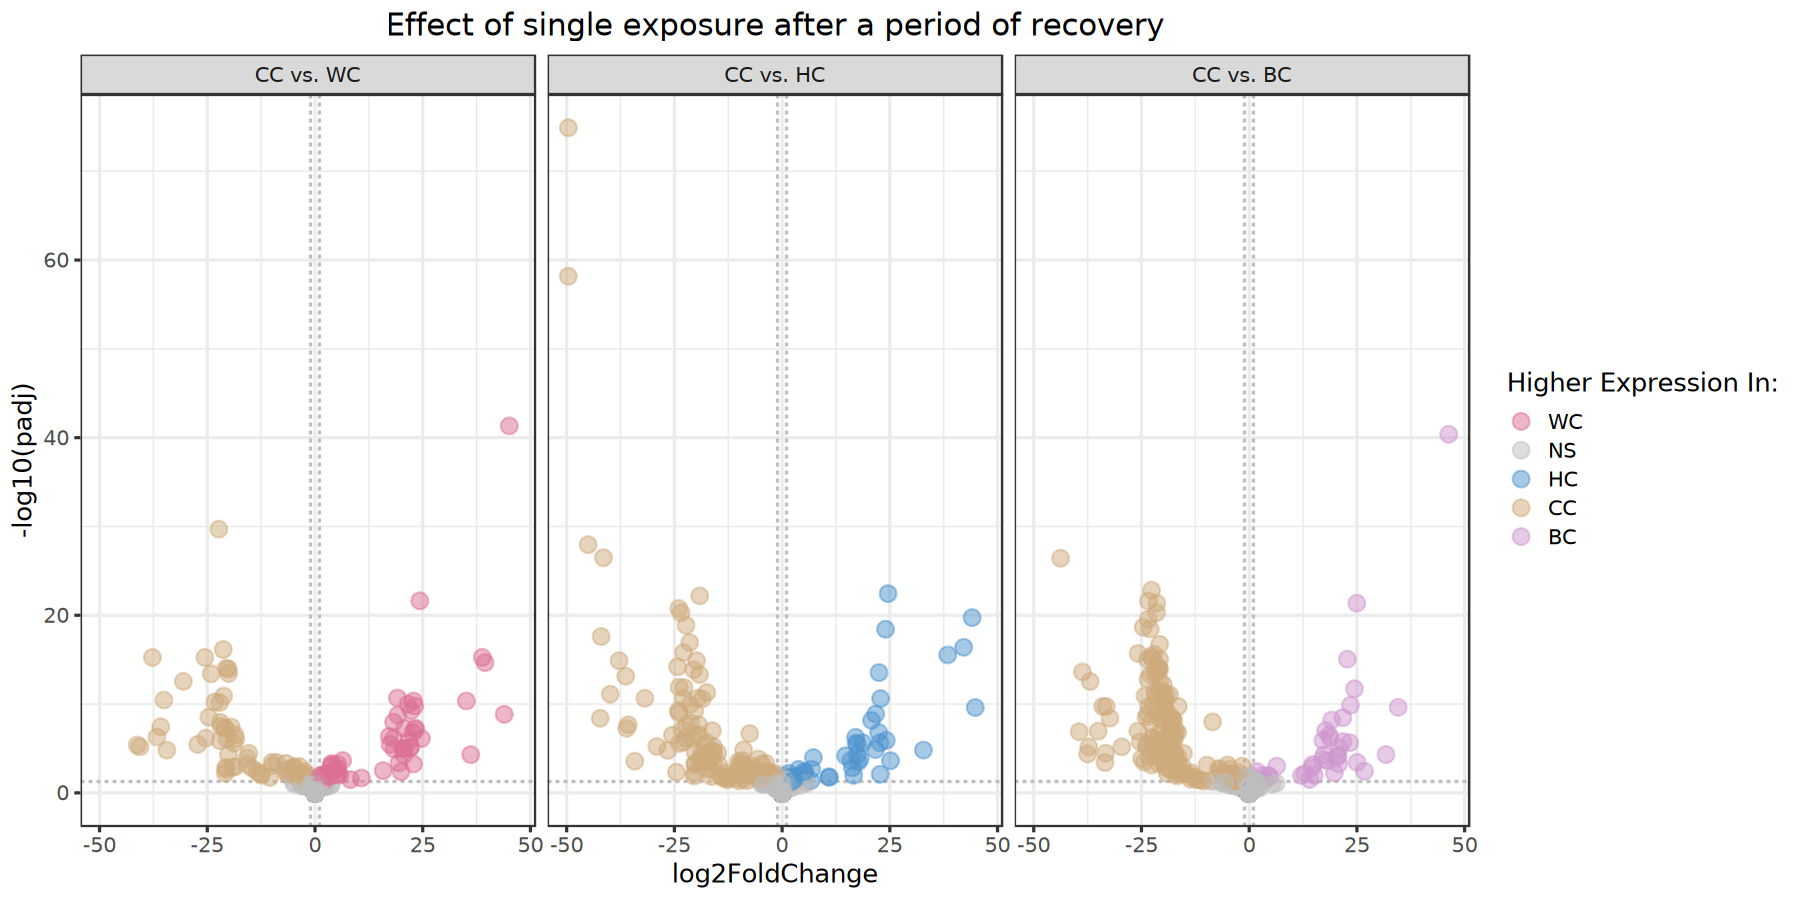

In [8]:
options(repr.plot.width=15, repr.plot.height=7.5)

# Specify the order for plots to follow Sophie's order
comp1$pair <- factor(comp1$pair, levels = c("CC vs. WC", "CC vs. HC", "CC vs. BC"))


comp1.plot <- ggplot(data = comp1,
                     aes(x = log2FoldChange,
                         y = -log10(padj),
                         col = DEG_group)) +
# fold change threshold line
geom_vline(xintercept = c(-1, 1), 
           col = "gray",
           linetype = "dashed") +
# adjusted p-value line
geom_hline(yintercept = -log10(0.05),
           col = "gray",
           linetype = "dashed") +
scale_color_manual(values = c("HC" = "steelblue3", "WC" = "palevioletred", "CC" = "burlywood3", "BC" = "plum3", "NS" = "grey")) +
facet_wrap(~pair) +
geom_point(size=4, alpha = 0.5) +
theme_bw(base_size = 15) +
theme(plot.title = element_text(hjust=.5)) + 
labs(col = 'Higher Expression In:',
    title = 'Effect of single exposure after a period of recovery') +
guides(col = guide_legend(reverse = TRUE))

comp1.plot

In [9]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/plots/comp1_volcano.pdf', comp1.plot, width=15, height=7.5)

Warning message:
“Removed 4508 rows containing missing values or values outside the scale range
(`geom_point()`).”


#### 2. Single exposure only experienced later in life

In [10]:
# combining dfs
comp2 <- rbind(deg_list$cw_cc, deg_list$ch_cc, deg_list$cb_cc)

# check things look okay
head(comp2)
tail(comp2)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111116054,9.0629842,-0.002810347,0.08942868,-0.2682325,0.78852039,1.0000000,0.9892307,1.875059,5.965799,⋯,11.19491,2.006592,7.359253,5.277065,2.300668,21.05700,1.075999,0.0000,CC vs. CW,NS
2,LOC111126949,539.2853993,0.018926071,0.08477087,0.9627117,0.33569222,0.9771461,0.9910207,829.713451,474.281013,⋯,506.25864,742.439160,650.373981,428.497663,480.839693,469.90350,302.355713,636.4963,CC vs. CW,NS
3,LOC111110729,114.0070007,0.060127893,0.08901711,2.1808881,0.02919169,0.6007896,0.9898775,60.001877,92.469883,⋯,87.07151,149.491128,111.308701,121.372491,144.942108,119.69240,136.651870,226.3334,CC vs. CW,NS
4,LOC111112434,6.9517032,-0.005446503,0.09926540,-0.6289035,0.52941224,1.0000000,0.9851196,10.312823,1.988600,⋯,13.68267,6.019777,3.679626,0.000000,2.300668,17.73221,8.607992,0.0000,CC vs. CW,NS
5,LOC111120752,429.0263780,-0.035951367,0.08477678,-1.5078882,0.13158314,0.8628621,0.9909672,337.510556,334.084739,⋯,446.55246,346.137176,402.919100,293.404804,330.145914,461.03739,358.307660,456.9172,CC vs. CW,NS
6,LOC111128944,0.1088474,0.001915011,0.33302781,0.1429308,0.88634483,NA,0.9639551,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,CC vs. CW,NS


,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
106393,ND4,201238.59,0.08535518,0.1330800,1.323379,0.18570934,0.8250478,0.9889950,172931.034,128590.81,⋯,232657.56,161231.700,158969.063,150933.553,246913.48,184216.58,148150.00,210908.75,CC vs. CB,NS
106394,ND5,210564.28,0.13228913,0.1427948,1.919496,0.05492155,0.5789353,0.9877385,185647.681,161139.21,⋯,285619.43,168043.078,141437.483,250349.232,295052.67,146413.73,210493.38,240616.87,CC vs. CB,NS
106395,ND6,63225.38,0.05891648,0.1373158,1.005524,0.31464454,0.9279978,0.9885223,39229.977,49181.05,⋯,65037.44,69710.021,45142.578,53080.940,55572.64,51206.18,51296.10,60055.93,CC vs. CB,NS
106396,ND3,37297.98,0.13152626,0.1692578,2.034647,0.04188645,0.5232814,0.9769956,21388.794,31453.68,⋯,45645.37,34658.866,31963.075,34293.533,39744.05,27421.75,30488.43,31331.77,CC vs. CB,NS
106397,ND1,182099.48,0.10041419,0.1371970,1.538874,0.12383517,0.7452159,0.9884114,138760.903,151767.94,⋯,194277.69,147349.091,142097.976,152530.392,260604.76,147909.88,187075.33,248166.63,CC vs. CB,NS
106398,ND4L,12213.37,0.14206614,0.1658313,2.106599,0.03515232,0.4935135,0.9812571,9108.097,10568.41,⋯,11910.14,9407.908,9196.306,9447.001,17288.37,10859.87,11466.92,16002.73,CC vs. CB,NS


Warning message:
“Removed 3143 rows containing missing values or values outside the scale range
(`geom_point()`).”


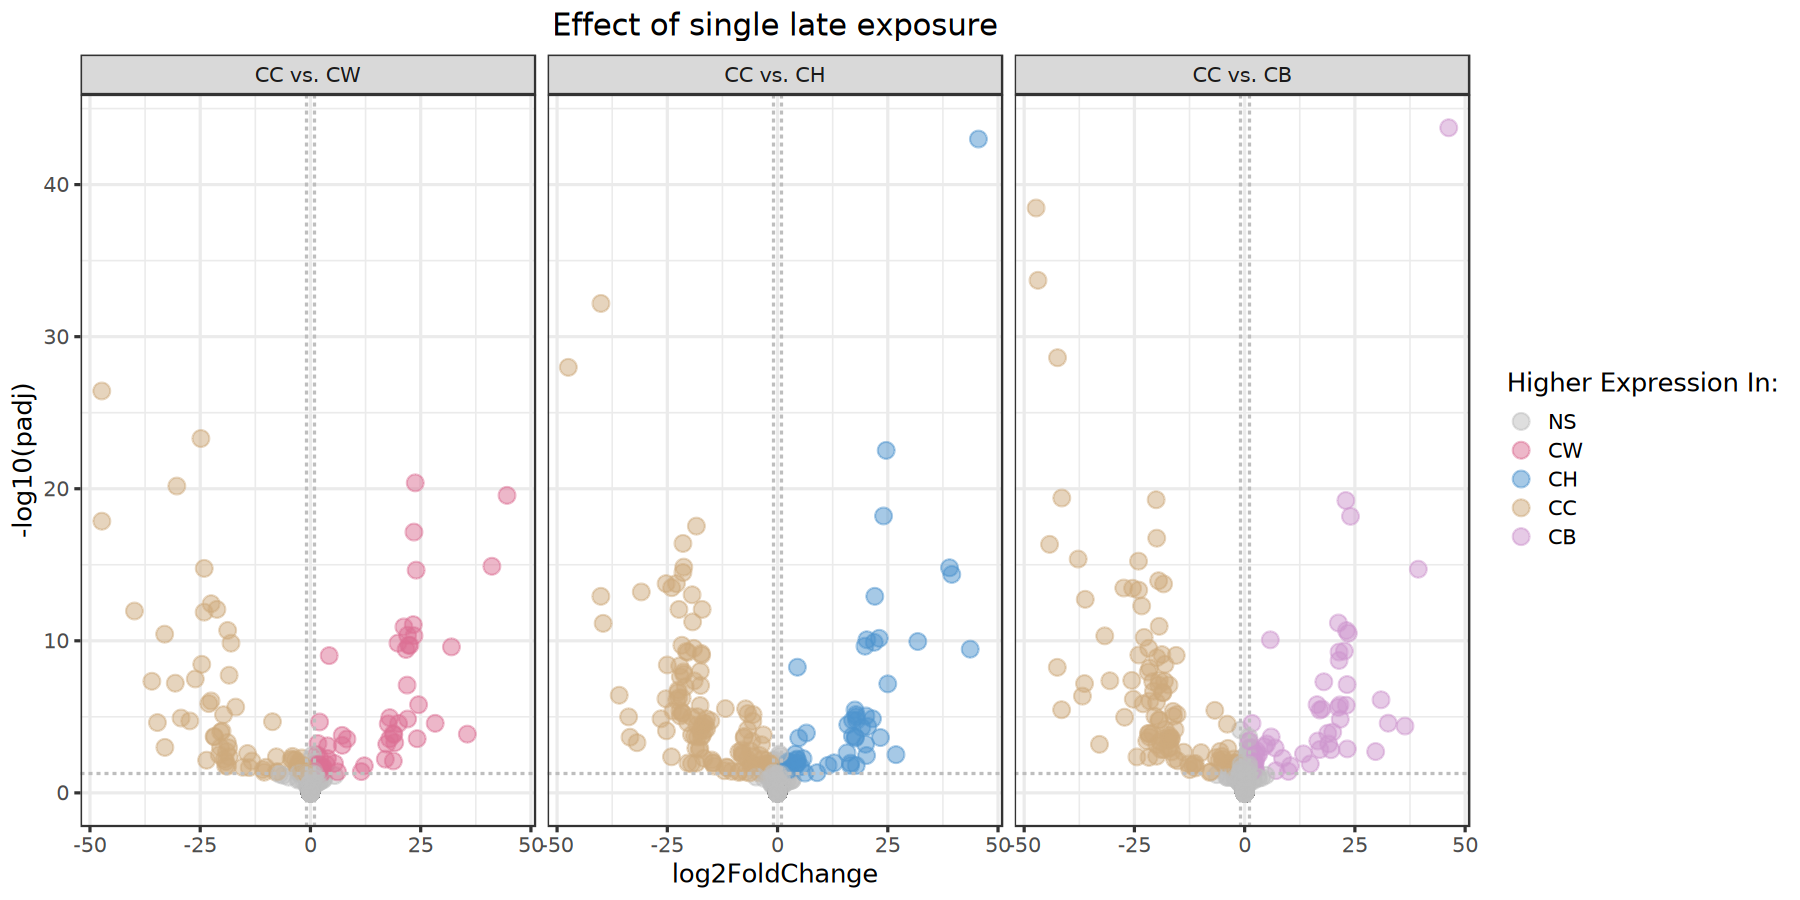

In [11]:
options(repr.plot.width=15, repr.plot.height=7.5)

# Specify the order for plots to follow Sophie's order
comp2$pair <- factor(comp2$pair, levels = c("CC vs. CW", "CC vs. CH", "CC vs. CB"))


comp2.plot <- ggplot(data = comp2,
                     aes(x = log2FoldChange,
                         y = -log10(padj),
                         col = DEG_group)) +
geom_point(size=4, alpha = 0.5) +
scale_color_manual(values = c("CH" = "steelblue3", "CW" = "palevioletred", "CC" = "burlywood3", "CB" = "plum3", "NS" = "grey")) +
# fold change threshold line
geom_vline(xintercept = c(-1, 1), 
           col = "gray",
           linetype = "dashed") +
# adjusted p-value line
geom_hline(yintercept = -log10(0.05),
           col = "gray",
           linetype = "dashed") +
facet_wrap(~pair) +
theme_bw(base_size = 15) +
theme(plot.title = element_text(hjust=.5)) + 
labs(col = 'Higher Expression In:',
    title = 'Effect of single late exposure') +
guides(col = guide_legend(reverse = TRUE))

comp2.plot

^ slightly confusing though bc i'm using the same color scheme as plot 1, but the colors denote different phase 1 and phase 2 exposures - will need to fix going forward but I'm not sure that this is super informative, given all the comparisons I have

#### 3. Effect of timing of initial stress exposure

In [21]:
# combining dfs
comp3 <- rbind(deg_list$cw_wc, deg_list$ch_hc, deg_list$cb_bc)

# check things look okay
head(comp3)
tail(comp3)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111116054,9.0629842,-0.028579189,0.1765320,-0.7058780,0.4802640,0.9105206,0.9831096,1.875059,5.965799,⋯,11.19491,2.006592,7.359253,5.277065,2.300668,21.05700,1.075999,0.0000,WC vs. CW,NS
2,LOC111126949,539.2853993,0.073618202,0.1593307,1.0532431,0.2922296,0.8128319,0.9874279,829.713451,474.281013,⋯,506.25864,742.439160,650.373981,428.497663,480.839693,469.90350,302.355713,636.4963,WC vs. CW,NS
3,LOC111110729,114.0070007,0.135167488,0.1453968,1.6219680,0.1048102,0.6139547,0.9886239,60.001877,92.469883,⋯,87.07151,149.491128,111.308701,121.372491,144.942108,119.69240,136.651870,226.3334,WC vs. CW,NS
4,LOC111112434,6.9517032,-0.006912183,0.1813588,-0.2267327,0.8206316,0.9935450,0.9831731,10.312823,1.988600,⋯,13.68267,6.019777,3.679626,0.000000,2.300668,17.73221,8.607992,0.0000,WC vs. CW,NS
5,LOC111120752,429.0263780,-0.030364866,0.1498546,-0.3899568,0.6965685,0.9723209,0.9898209,337.510556,334.084739,⋯,446.55246,346.137176,402.919100,293.404804,330.145914,461.03739,358.307660,456.9172,WC vs. CW,NS
6,LOC111128944,0.1088474,0.002530254,0.4073713,0.1254499,0.9001674,NA,0.9569139,0.000000,0.000000,⋯,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,WC vs. CW,NS


,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
106393,ND4,201238.59,0.08788350,0.1435409,1.380901,0.16730942,0.7686848,0.9850068,172931.034,128590.81,⋯,232657.56,161231.700,158969.063,150933.553,246913.48,184216.58,148150.00,210908.75,BC vs. CB,NS
106394,ND5,210564.28,0.13252402,0.1591088,1.875909,0.06066776,0.5557105,0.9836033,185647.681,161139.21,⋯,285619.43,168043.078,141437.483,250349.232,295052.67,146413.73,210493.38,240616.87,BC vs. CB,NS
106395,ND6,63225.38,0.12021705,0.1707599,1.844322,0.06513616,0.5708168,0.9792778,39229.977,49181.05,⋯,65037.44,69710.021,45142.578,53080.940,55572.64,51206.18,51296.10,60055.93,BC vs. CB,NS
106396,ND3,37297.98,0.13089240,0.1790833,1.977231,0.04801552,0.5044097,0.9749840,21388.794,31453.68,⋯,45645.37,34658.866,31963.075,34293.533,39744.05,27421.75,30488.43,31331.77,BC vs. CB,NS
106397,ND1,182099.48,0.09365152,0.1465152,1.457416,0.14500166,0.7358223,0.9846413,138760.903,151767.94,⋯,194277.69,147349.091,142097.976,152530.392,260604.76,147909.88,187075.33,248166.63,BC vs. CB,NS
106398,ND4L,12213.37,0.11005655,0.1618942,1.702699,0.08862436,0.6267247,0.9819081,9108.097,10568.41,⋯,11910.14,9407.908,9196.306,9447.001,17288.37,10859.87,11466.92,16002.73,BC vs. CB,NS


In [22]:
comp3 <- comp3 %>%
# add phase 1 info for DEG
mutate(deg_p1 = case_when(
    str_starts(DEG_group, 'C') ~ 'Control',
    str_starts(DEG_group, 'W') ~ 'Warm',
    str_starts(DEG_group, 'H') ~ 'Hypoxic',
    str_starts(DEG_group, 'B') ~ 'Both',
    TRUE ~ 'NS')) %>%
# add phase 2 info for DEG
mutate(deg_p2 = case_when(
    str_ends(DEG_group, 'C') ~ 'Control',
    str_ends(DEG_group, 'W') ~ 'Warm',
    str_ends(DEG_group, 'H') ~ 'Hypoxic',
    str_ends(DEG_group, 'B') ~ 'Both',
    TRUE ~ 'NS'))

head(comp3)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group,deg_p1,deg_p2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,LOC111116054,9.0629842,-0.028579189,0.1765320,-0.7058780,0.4802640,0.9105206,0.9831096,1.875059,5.965799,⋯,7.359253,5.277065,2.300668,21.05700,1.075999,0.0000,WC vs. CW,NS,NS,NS
2,LOC111126949,539.2853993,0.073618202,0.1593307,1.0532431,0.2922296,0.8128319,0.9874279,829.713451,474.281013,⋯,650.373981,428.497663,480.839693,469.90350,302.355713,636.4963,WC vs. CW,NS,NS,NS
3,LOC111110729,114.0070007,0.135167488,0.1453968,1.6219680,0.1048102,0.6139547,0.9886239,60.001877,92.469883,⋯,111.308701,121.372491,144.942108,119.69240,136.651870,226.3334,WC vs. CW,NS,NS,NS
4,LOC111112434,6.9517032,-0.006912183,0.1813588,-0.2267327,0.8206316,0.9935450,0.9831731,10.312823,1.988600,⋯,3.679626,0.000000,2.300668,17.73221,8.607992,0.0000,WC vs. CW,NS,NS,NS
5,LOC111120752,429.0263780,-0.030364866,0.1498546,-0.3899568,0.6965685,0.9723209,0.9898209,337.510556,334.084739,⋯,402.919100,293.404804,330.145914,461.03739,358.307660,456.9172,WC vs. CW,NS,NS,NS
6,LOC111128944,0.1088474,0.002530254,0.4073713,0.1254499,0.9001674,NA,0.9569139,0.000000,0.000000,⋯,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,WC vs. CW,NS,NS,NS


In [23]:
unique(comp3$pair)

[1] "WC vs. CW" "HC vs. CH" "BC vs. CB"

Warning message:
“Removed 3143 rows containing missing values or values outside the scale range
(`geom_point()`).”


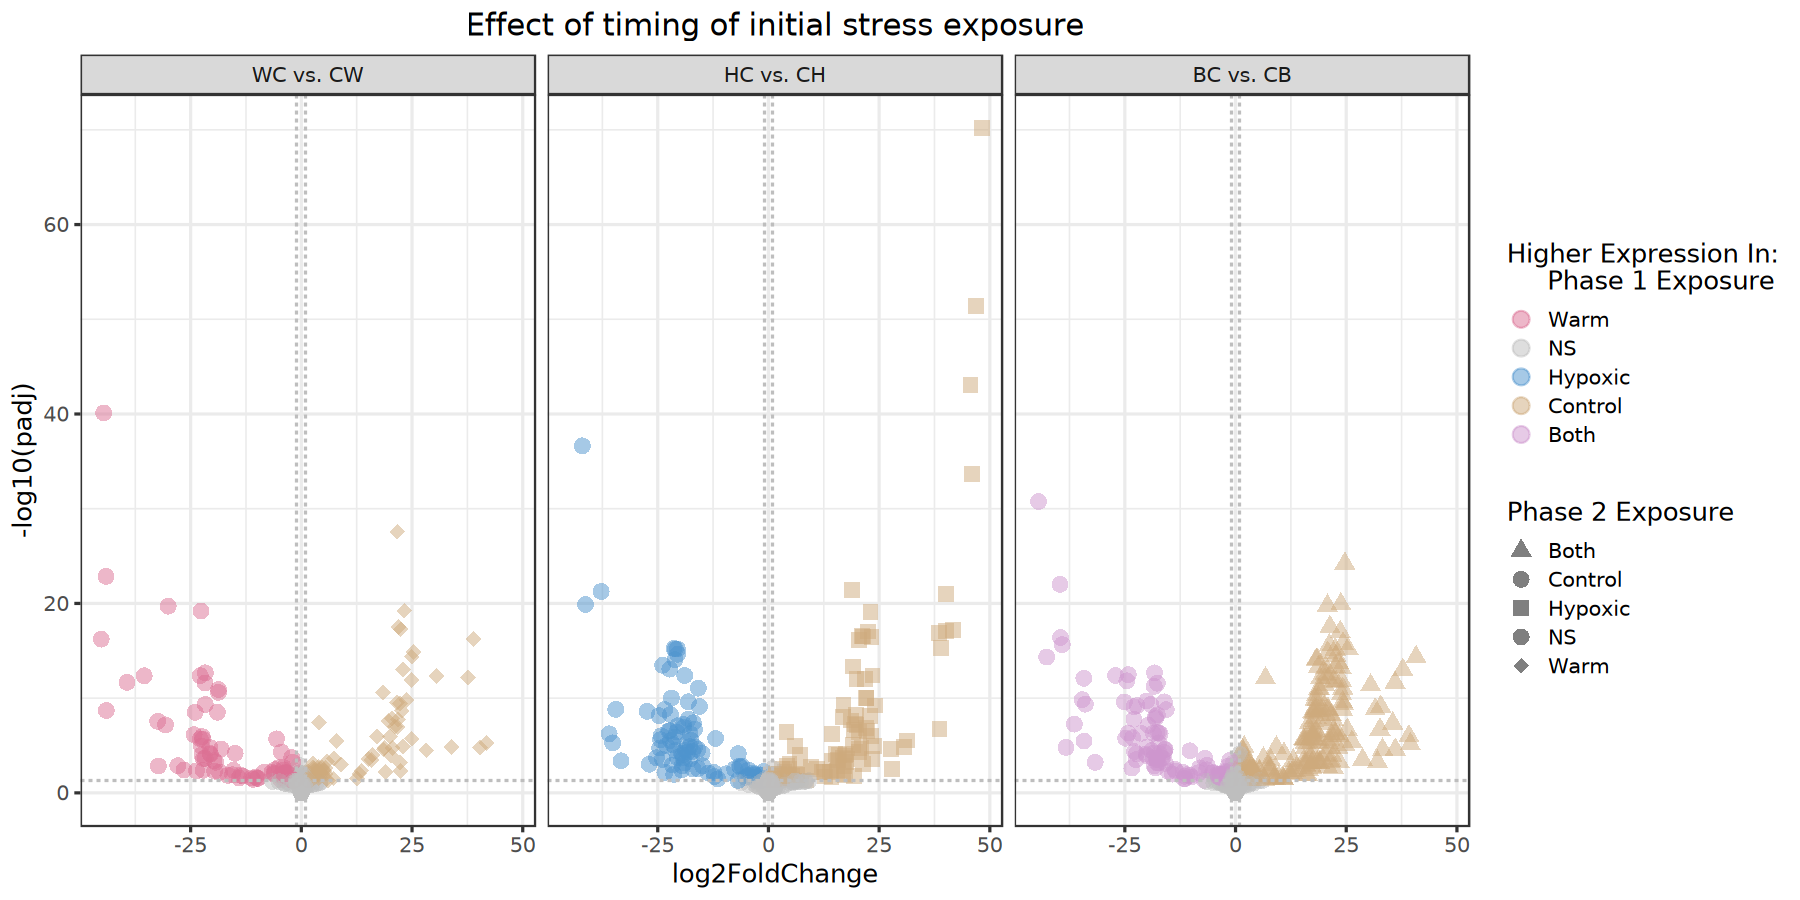

In [24]:
options(repr.plot.width=15, repr.plot.height=7.5)

# Specify the order for plots to follow Sophie's order
comp3$pair <- factor(comp3$pair, levels = c("WC vs. CW", "HC vs. CH", "BC vs. CB"))


comp3.plot <- ggplot(data = comp3,
                     aes(x = log2FoldChange,
                         y = -log10(padj),
                         col = deg_p1,
                        shape = deg_p2)) +
geom_point(size=4, alpha = 0.5) +
# select colors for phase 1
scale_color_manual(values = c("Hypoxic" = "steelblue3", 
                              "Warm" = "palevioletred", 
                              "Control" = "burlywood3", 
                              "Both" = "plum3", 
                              "NS" = "grey")) +
# select shapes for phase 2
scale_shape_manual(values = c(
    'Hypoxic' = 15,
    'Warm' = 18,
    'Control' = 16,
    'Both' = 17,
    'NS' = 16)) +
# fold change threshold line
geom_vline(xintercept = c(-1, 1), 
           col = "gray",
           linetype = "dashed") +
# adjusted p-value line
geom_hline(yintercept = -log10(0.05),
           col = "gray",
           linetype = "dashed") +
facet_wrap(~pair) +
theme_bw(base_size = 15) +
theme(plot.title = element_text(hjust=.5)) + 
labs(col = 'Higher Expression In:
     Phase 1 Exposure',
     shape = 'Phase 2 Exposure',
    title = 'Effect of timing of initial stress exposure') +
guides(col = guide_legend(reverse = TRUE, order = 1))

comp3.plot